# Test Methods

In [1]:
import pickle
with open('ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

In [2]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho'][:]
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho'][:]
lat_rho = np.transpose(lat_rho, axes=(1, 0))
f  = dataset.variables['f'][:]
f = np.transpose(f, axes=(1, 0))
z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
temp_ave = np.load('/srv/scratch/z5297792/Climatology/temp_ave.npy')
CurSpeed_ave = np.load('/srv/scratch/z5297792/Climatology/CurSpeed_ave.npy')
previous_file_idx1, previous_file_idx2, previous_file_idx3, previous_file_idx4 = -1
TOTAL_NUM_DAYS = len(daydic)

In [3]:
import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None

def grid_finder(i_search, j_search, SEARCH_WIDTH):
    fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
    dataset = nc.Dataset(fname)
    lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
    lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
    
    def within_search_width(i_offset, j_offset):
        return distance(lat_rho[i_search, j_search], lon_rho[i_search, j_search],
                        lat_rho[i_search + i_offset, j_search + j_offset], 
                        lon_rho[i_search + i_offset, j_search + j_offset]) < SEARCH_WIDTH / 2

    i_left, i_right = 0, 0
    j_down, j_up = 0, 0

    while i_search - i_left >= 0 and within_search_width(-i_left, 0):
        i_left += 1
    while i_search + i_right < lon_rho.shape[0] and within_search_width(i_right, 0):
        i_right += 1
    while j_search - j_down >= 0 and within_search_width(0, -j_down):
        j_down += 1
    while j_search + j_up < lon_rho.shape[1] and within_search_width(0, j_up):
        j_up += 1

    i_left = max(i_search - i_left + 1, 0)
    i_right = min(i_search + i_right, lon_rho.shape[0])
    j_down = max(j_search - j_down + 1, 0)
    j_up = min(j_search + j_up, lon_rho.shape[1])

    return i_left, i_right, j_down, j_up

def eddies_nearest_rho(elon, elat):
    dataset = nc.Dataset('/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc')
    lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
    lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
    R = np.sqrt((lon_rho - elon)**2 + (lat_rho - elat)**2)
    i_search, j_search = np.unravel_index(np.argmin(R), R.shape)
    return i_search, j_search

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357000
    lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
    lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)
    dlat, dlon = lat2_rad - lat1_rad, lon2_rad - lon1_rad
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

def find_global_maxima(matrix):
    i_max, j_max = np.unravel_index(np.argmax(matrix, axis=None), matrix.shape)
    return i_max, j_max

def find_local_maxima(matrix):
    def is_local_maxima(matrix, i, j):
        rows, cols = matrix.shape
        value = matrix[i, j]
        if np.isnan(value):
            return False
        def is_valid_and_greater_than(value, neighbor):
            return not np.isnan(neighbor) and neighbor > value
        if i > 0 and is_valid_and_greater_than(value, matrix[i - 1, j]):
            return False
        if i < rows - 1 and is_valid_and_greater_than(value, matrix[i + 1, j]):
            return False
        if j > 0 and is_valid_and_greater_than(value, matrix[i, j - 1]):
            return False
        if j < cols - 1 and is_valid_and_greater_than(value, matrix[i, j + 1]):
            return False
        if i > 0 and j > 0 and is_valid_and_greater_than(value, matrix[i - 1, j - 1]):
            return False
        if i > 0 and j < cols - 1 and is_valid_and_greater_than(value, matrix[i - 1, j + 1]):
            return False
        if i < rows - 1 and j > 0 and is_valid_and_greater_than(value, matrix[i + 1, j - 1]):
            return False
        if i < rows - 1 and j < cols - 1 and is_valid_and_greater_than(value, matrix[i + 1, j + 1]):
            return False
        return True
    i_max, j_max, value_max = [], [], []
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if is_local_maxima(matrix, i, j):
                i_max.append(i)
                j_max.append(j)
                value_max.append(matrix[i, j])
    return i_max, j_max, value_max

def eddies_nearest_rho(elon, elat):
    dataset = nc.Dataset('/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc')
    lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
    lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
    R = np.sqrt((lon_rho - elon)**2 + (lat_rho - elat)**2)
    i_search, j_search = np.unravel_index(np.argmin(R), R.shape)
    return i_search, j_search

def get_variable_name(var):
    for name, value in globals().items():
        if value is var:
            split_name = re.sub(r'([a-z])([A-Z])', r'\1 \2', name)
            return split_name
    return None

def make_cartesian(lon, lat, theta0, phi0):
    lonr, latr = np.deg2rad(lon), np.deg2rad(lat)
    r_earth = 6371
    x = r_earth * np.cos(np.deg2rad(phi0)) * (lonr - np.deg2rad(theta0))
    y = r_earth * (latr - np.deg2rad(phi0))
    return x, y

def eddy_centric_grid_distances(i_search, j_search, i_left, i_right, j_down, j_up):
    lonc = lon_rho[i_search, j_search]
    latc = lat_rho[i_search, j_search]
    def make_left_values_negative(arr):
        zero_index = np.where(arr == 0)[0]
        if zero_index.size == 0:
            return arr
        zero_index = zero_index[0]
        arr[:zero_index] = -np.abs(arr[:zero_index])
        return arr
    x = make_left_values_negative(distance(latc, lonc, lat_rho[i_left:i_right,j_search], lon_rho[i_left:i_right,j_search]))
    y = make_left_values_negative(distance(latc, lonc, lat_rho[i_search,j_down:j_up], lon_rho[i_search,j_down:j_up]))
    return x.data/1000, y.data/1000

def rotate_20_clockwise(x, y):
    theta = np.deg2rad(20)
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    points = np.vstack((x, y))
    rotated_points = rotation_matrix @ points
    x_rotated, y_rotated = rotated_points
    return x_rotated, y_rotated

def extract_contour(level_to_extract, plot):
    for level_paths in plot.allsegs:
        for path in level_paths:
            xt = path[:, 0]
            yt = path[:, 1]
            return xt, yt
    else:
        return [], []

In [61]:
edata = eddies['Eddy24'] 

t0 = extract_number(edata.iloc[0].name)
tN = extract_number(edata.iloc[-1].name)

# Initialize arrays
U1 = np.zeros((lon_rho.shape[0], lon_rho.shape[1], z_r.shape[-1], tN - t0))
V1 = np.zeros_like(U1)
Vorticity1 = np.zeros_like(U1)
TemperatureAnomaly1 = np.zeros_like(U1)
CurSpeed1 = np.zeros_like(U1)
OW1 = np.zeros_like(U1)

# Calculate time moduli
t_mod0 = t0 % 30
t_modN = tN % 30
file_idx0 = int(t0 // 30)
file_idxN = int(tN // 30)

# Loop through the files as needed
for file_idx in range(file_idx0, file_idxN + 1):
    fnumber = '0' + str(round(1461 + file_idx * 30))
    fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_' + fnumber + '.nc'
    
    if file_idx == file_idx0:
        t_pres = 30 - t_mod0
        start_idx = t_mod0
        end_idx = 30 if file_idx != file_idxN else t_modN
    elif file_idx == file_idxN:
        start_idx = 0
        end_idx = t_modN
    else:
        start_idx = 0
        end_idx = 30

    # Load the data from the file
    U_chunk = np.load(f'/srv/scratch/z5297792/Climatology/u_v/u_{fnumber}.npy')[:, :, :, start_idx:end_idx]
    V_chunk = np.load(f'/srv/scratch/z5297792/Climatology/u_v/v_{fnumber}.npy')[:, :, :, start_idx:end_idx]
    Vorticity_chunk = np.load(f'/srv/scratch/z5297792/Climatology/vorts/vort_{fnumber}.npy')[:, :, :, start_idx:end_idx]
    Temp_chunk = np.load(f'/srv/scratch/z5297792/Climatology/temps/temp_{fnumber}.npy')[:, :, :, start_idx:end_idx] - temp_ave[:, :, :, np.newaxis]
    CurSpeed_chunk = np.load(f'/srv/scratch/z5297792/Climatology/ow_and_cur_speeds/cur_speed_{fnumber}.npy')[:, :, :, start_idx:end_idx]
    OW_chunk = np.load(f'/srv/scratch/z5297792/Climatology/ow_and_cur_speeds/ow_{fnumber}.npy')[:, :, :, start_idx:end_idx]

    # Fill the data in the relevant arrays
    if file_idx == file_idx0:
        U1[:, :, :, :t_pres] = U_chunk
        V1[:, :, :, :t_pres] = V_chunk
        Vorticity1[:, :, :, :t_pres] = Vorticity_chunk
        TemperatureAnomaly1[:, :, :, :t_pres] = Temp_chunk
        CurSpeed1[:, :, :, :t_pres] = CurSpeed_chunk
        OW1[:, :, :, :t_pres] = OW_chunk
    elif file_idx == file_idxN:
        U1[:, :, :, t_pres:] = U_chunk
        V1[:, :, :, t_pres:] = V_chunk
        Vorticity1[:, :, :, t_pres:] = Vorticity_chunk
        TemperatureAnomaly1[:, :, :, t_pres:] = Temp_chunk
        CurSpeed1[:, :, :, t_pres:] = CurSpeed_chunk
        OW1[:, :, :, t_pres:] = OW_chunk
    else:
        U1[:, :, :, t_pres:(t_pres + 30)] = U_chunk
        V1[:, :, :, t_pres:(t_pres + 30)] = V_chunk
        Vorticity1[:, :, :, t_pres:(t_pres + 30)] = Vorticity_chunk
        TemperatureAnomaly1[:, :, :, t_pres:(t_pres + 30)] = Temp_chunk
        CurSpeed1[:, :, :, t_pres:(t_pres + 30)] = CurSpeed_chunk
        OW1[:, :, :, t_pres:(t_pres + 30)] = OW_chunk
        t_pres += 30


U1 = np.where(U1 > 1e30, 0, U1)
V1 = np.where(V1 > 1e30, 0, V1)

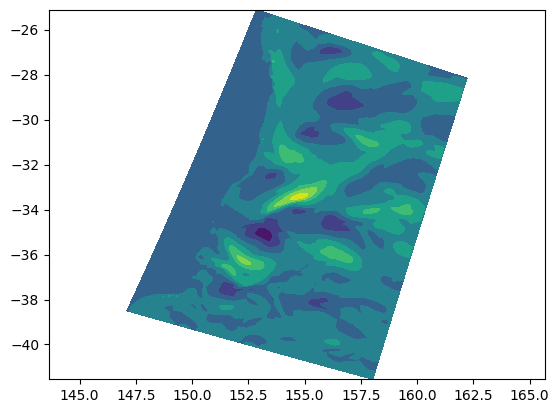

AttributeError: module 'matplotlib.pyplot' has no attribute 'clear'

In [105]:
for t in range(U1.shape[-1]):
    plt.contourf(lon_rho, lat_rho, U1[:, :, 0, t])
    plt.axis('equal')
    plt.pause(.2)
    plt.clear()










In [45]:
eddies['Eddy24']

,Lon,Lat,Vort,Id,Age
Day1,155.314312,-31.147566,0.000037,24.0,55
Day2,155.176226,-31.199155,0.000034,24.0,55
Day3,155.147814,-31.379504,0.000035,24.0,55
Day4,155.151547,-31.475239,0.000037,24.0,55
Day5,155.207603,-31.539910,0.000036,24.0,55
Day6,155.280650,-31.562565,0.000030,24.0,55
Day7,155.392268,-31.597172,0.000031,24.0,55
Day8,155.499539,-31.535962,0.000035,24.0,55
Day9,155.531021,-31.451264,0.000037,24.0,55
Day10,155.546756,-31.408915,0.000037,24.0,55


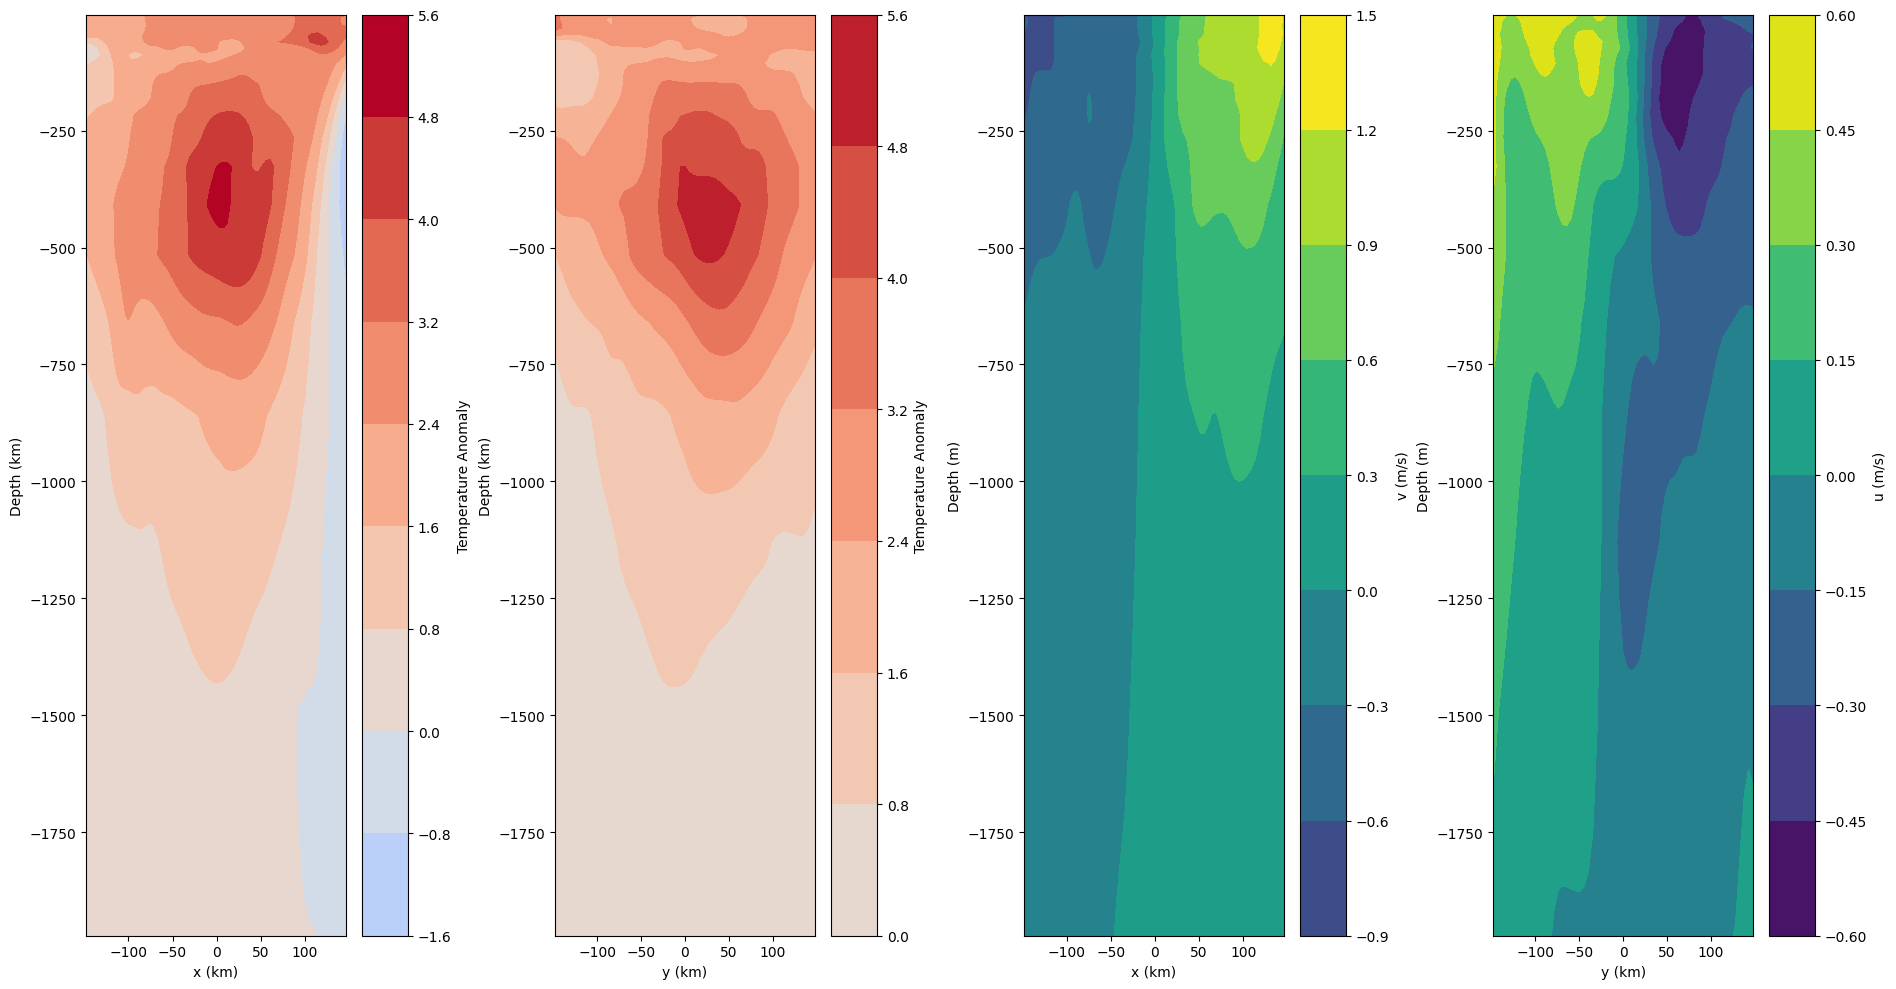

In [44]:
import matplotlib.colors as mcolors

DISPLAY_WIDTH = 300000
DEPTH_LVL_LIMIT = 25

DataField1 = TemperatureAnomaly

DataField1_name = get_variable_name(DataField1)
DataField1 = np.squeeze(DataField1[:, :, :, t_mod])

i_left, i_right, j_down, j_up = grid_finder(i_search, j_search, DISPLAY_WIDTH)
x, y = eddy_centric_grid_distances(i_search, j_search, i_left, i_right, j_down, j_up)

fig, axs = plt.subplots(1, 4, figsize=(19, 10))

# First subplot
DataField1_cross = DataField1[i_left:i_right, j_search, :DEPTH_LVL_LIMIT]
X, Z = np.meshgrid(x, z_r[150, 150, :DEPTH_LVL_LIMIT])
DataField1_data_range = np.nanmax(np.abs(DataField1_cross))
c1 = axs[0].contourf(X, Z, DataField1_cross.T, cmap='coolwarm', vmin=-DataField1_data_range, vmax=DataField1_data_range)
axs[0].set_xlabel('x (km)')
axs[0].set_ylabel('Depth (km)')
fig.colorbar(c1, ax=axs[0], label=DataField1_name)

# Second subplot
DataField1_cross = DataField1[i_search, j_down:j_up, :DEPTH_LVL_LIMIT] 
Y, Z = np.meshgrid(y, z_r[150, 150, :DEPTH_LVL_LIMIT])
DataField1_data_range = np.nanmax(np.abs(DataField1_cross))
c2 = axs[1].contourf(Y, Z, DataField1_cross.T, cmap='coolwarm', vmin=-DataField1_data_range, vmax=DataField1_data_range)
axs[1].set_xlabel('y (km)')
axs[1].set_ylabel('Depth (km)')
fig.colorbar(c2, ax=axs[1], label=DataField1_name)

# Second subplot
v_cross = V[i_left:i_right, j_search, :DEPTH_LVL_LIMIT, t_mod]
v_data_range = np.nanmax(np.abs(v_cross))
X, Z = np.meshgrid(x, z_r[150, 150, :DEPTH_LVL_LIMIT])
c1 = axs[2].contourf(X, Z, v_cross.T, cmap='viridis', vmin=-v_data_range, vmax=v_data_range)
axs[2].set_xlabel('x (km)')
axs[2].set_ylabel('Depth (m)')
fig.colorbar(c1, ax=axs[2], label='v (m/s)')

# Third subplot
u_cross = U[i_search, j_down:j_up, :DEPTH_LVL_LIMIT, t_mod]
u_data_range = np.nanmax(np.abs(u_cross))
Y, Z = np.meshgrid(y, z_r[150, 150, :DEPTH_LVL_LIMIT])
c2 = axs[3].contourf(Y, Z, u_cross.T, cmap='viridis', vmin=-u_data_range, vmax=u_data_range)
axs[3].set_xlabel('y (km)')
axs[3].set_ylabel('Depth (m)')
fig.colorbar(c2, ax=axs[3], label='u (m/s)')

plt.tight_layout()
plt.show()